In [10]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from sklearn.model_selection import train_test_split

In [ ]:
wandb.init(project="CPPNsquared")

#### Hyperparameters

In [12]:

device = 'cuda'
num_steps = 500
batch_size = 8512
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [14]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('CPPN_model.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
# model_path = ('CPPN_model.pt')
# original = torch.load(model_path)
# print(original)

In [17]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

False


#### Map spacial coordinates

In [18]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        full_coords.extend(temp_coords)
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)
print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

# print(layer1_arragned)
    
    # getting seemingly random output here 
        

Parameter containing:
tensor([[-5.8847e-01,  4.1669e-01],
        [-2.7095e-01,  6.4963e-02],
        [ 2.9956e-01, -2.5943e-01],
        [ 2.7741e-01,  2.7138e-01],
        [ 6.5063e-01,  3.2685e-01],
        [ 6.0555e-01, -3.1997e-01],
        [-1.8970e-01, -3.7469e-01],
        [-2.6461e-01, -3.2470e-01],
        [ 4.7824e-01, -1.2916e-01],
        [-2.3546e-01, -6.6540e-01],
        [ 5.5303e-02, -3.8402e-01],
        [ 1.8463e-01, -6.3161e-01],
        [ 8.6686e-02,  2.5185e-01],
        [-2.1596e-01,  6.3986e-01],
        [-5.8892e-01, -7.2488e-02],
        [-5.4971e-01, -4.8549e-01],
        [ 2.3224e-01, -2.7707e-01],
        [ 3.2106e-01, -8.5644e-02],
        [-1.2858e-01, -3.8868e-01],
        [-2.7333e-01, -7.0093e-01],
        [-4.6994e-01, -4.3734e-02],
        [ 5.7609e-01, -3.7389e-01],
        [ 4.9842e-01,  2.4089e-01],
        [-5.7483e-04, -6.2848e-01],
        [-5.2915e-01,  1.6625e-01],
        [-5.1193e-01, -6.1918e-01],
        [ 7.7575e-02, -5.1660e-01],
      

#### Set up CPPN_squared

In [19]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 4)

      # self.fc2 = nn.Linear(16, 16)
      # self.fce1 = nn.Linear(32, 64)
      # self.fce2 = nn.Linear(64,128)

      self.fc3 = nn.Linear(4, 1)     
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = F.relu(x)

        # x = self.fc2(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [20]:
CPPN_squared = CPPN_squared()
wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)

criterion = nn.MSELoss(reduction='sum')

# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [21]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [22]:
all_xy_coordinates = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([[-1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9683, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9683],
        ...,
        [ 1.0000,  0.9365,  1.0000, -0.9365],
        [ 1.0000,  0.9683,  1.0000, -0.9365],
        [ 1.0000,  1.0000,  1.0000, -0.9365]], device='cuda:0')
tensor([0.2058, 0.7083, 0.3645,  ..., 0.5579, 0.5615, 0.5583], device='cuda:0')


#### Split training and validation set


In [23]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.2, random_state=42)
# import math
batch_size = int(batch_size * 0.8)

In [24]:
print(normalized_coords_matrix)

tensor([[-1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9683, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9683],
        ...,
        [ 1.0000,  0.9365,  1.0000, -0.9365],
        [ 1.0000,  0.9683,  1.0000, -0.9365],
        [ 1.0000,  1.0000,  1.0000, -0.9365]], device='cuda:0')


In [25]:
num_coords = all_xy_coordinates.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

# training loop
for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    # Sample a random batch of indexes from the list coord_indexes
    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))
    
    # Get batch of respective xy_coordiantes
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    # And respective pixel values 
    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)
    
    # Process data with model
    approx_pixel_values = CPPN_squared(training_coords_batch)
    
    # Calculate and track loss function
    loss = criterion(pixel_values_batch, approx_pixel_values)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % 1 == 0:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'CPPN2model.pt')
        print(f'step {i}, loss {running_loss:.3f}')
        wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0
            #should i iterate through them one by one or just do the whole thing?
            # for i in range(val_coords.shape[0]):
            #     val_output = CPPN_squared(val_coords[i])
            #     val_loss += criterion(val_pixel_values[i], val_output.unsqueeze(0)).item()
            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_pixel_values, val_output.unsqueeze(0)).item()
            val_loss /= val_coords.shape[0]

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_weights = CPPN_squared.state_dict()
                torch.save(best_model_weights, 'best_CPPN2_weights.pt')
                
            print(f'Validation - Step {i}, loss {val_loss:.3f}')
            wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    wandb.log({"final_weights": CPPN_squared.state_dict()})

step 0, loss 0.024
Validation - Step 0, loss 6.420
step 1, loss 0.024
Validation - Step 1, loss 6.341
step 2, loss 0.024
Validation - Step 2, loss 6.265
step 3, loss 0.023
Validation - Step 3, loss 6.190
step 4, loss 0.023
Validation - Step 4, loss 6.118
step 5, loss 0.023
Validation - Step 5, loss 6.046
step 6, loss 0.022
Validation - Step 6, loss 5.977


e:\anaconda3\envs\AI4M\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1703, 1])) that is different to the input size (torch.Size([1703])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


step 7, loss 0.022
Validation - Step 7, loss 5.909
step 8, loss 0.022
Validation - Step 8, loss 5.844
step 9, loss 0.022
Validation - Step 9, loss 5.780
step 10, loss 0.021
Validation - Step 10, loss 5.717
step 11, loss 0.021
Validation - Step 11, loss 5.657
step 12, loss 0.021
Validation - Step 12, loss 5.598
step 13, loss 0.021
Validation - Step 13, loss 5.541
step 14, loss 0.020
Validation - Step 14, loss 5.485
step 15, loss 0.020
Validation - Step 15, loss 5.432
step 16, loss 0.020
Validation - Step 16, loss 5.379
step 17, loss 0.020
Validation - Step 17, loss 5.329
step 18, loss 0.020
Validation - Step 18, loss 5.280
step 19, loss 0.019
Validation - Step 19, loss 5.232
step 20, loss 0.019
Validation - Step 20, loss 5.186
step 21, loss 0.019
Validation - Step 21, loss 5.141
step 22, loss 0.019
Validation - Step 22, loss 5.098
step 23, loss 0.019
Validation - Step 23, loss 5.057
step 24, loss 0.019
Validation - Step 24, loss 5.016
step 25, loss 0.018
Validation - Step 25, loss 4.977

In [26]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([0.4920, 0.4911, 0.4924, 0.4915, 0.4927, 0.4918, 0.4930, 0.4921, 0.4934,
        0.4925, 0.4937, 0.4928, 0.4941, 0.4931, 0.4944, 0.4935, 0.4947, 0.4938,
        0.4951, 0.4942, 0.4954, 0.4945, 0.4957, 0.4948, 0.4961, 0.4952, 0.4964,
        0.4955, 0.4967, 0.4958, 0.4971, 0.4962, 0.4974, 0.4965, 0.4978, 0.4968,
        0.4981, 0.4972, 0.4984, 0.4975, 0.4988, 0.4978, 0.4991, 0.4982, 0.4994,
        0.4985, 0.4998, 0.4989, 0.5001, 0.4992, 0.5004, 0.4995, 0.5008, 0.4999,
        0.5011, 0.5002, 0.5014, 0.5005, 0.5014, 0.5009, 0.5014, 0.5012, 0.5014,
        0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014,
        0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014, 0.5014,
        0.5015, 0.5014, 0.5018, 0.5014, 0.5022, 0.5014, 0.5025, 0.5018, 0.5029,
        0.5021, 0.5032, 0.5025, 0.5036, 0.5028, 0.5039, 0.5031, 0.5043, 0.5035,
        0.5046, 0.5038, 0.5049, 0.5042, 0.5053, 0.5045, 0.5055, 0.5043, 0.5050,
        0.5038, 0.5045, 0.5033, 0.5040, 

In [28]:
print(all_pixel_values)

tensor([0.2058, 0.7083, 0.3645, 0.5325, 0.6498, 0.3703, 0.6387, 0.6357, 0.8253,
        0.6634, 0.8028, 0.3400, 0.4052, 0.3127, 0.3677, 0.3376, 0.7391, 0.4354,
        0.3823, 0.1673, 0.5277, 0.3080, 0.5923, 0.1842, 0.5433, 0.6259, 0.3920,
        0.8199, 0.2055, 0.4638, 0.2251, 0.2573, 0.6161, 0.3615, 0.6605, 0.4572,
        0.4357, 0.3057, 0.3633, 0.1495, 0.2650, 0.4781, 0.7880, 0.3131, 0.7492,
        0.6204, 0.4997, 0.1858, 0.2354, 0.5831, 0.2440, 0.1904, 0.5388, 0.2417,
        0.3035, 0.6521, 0.5410, 0.4364, 0.5218, 0.6523, 0.1583, 0.5860, 0.2506,
        0.1755, 0.2200, 0.1477, 0.7324, 0.3806, 0.6354, 0.7291, 0.3360, 0.5391,
        0.2973, 0.7643, 0.1854, 0.2289, 0.1484, 0.7633, 0.6245, 0.5501, 0.1510,
        0.5027, 0.8317, 0.4305, 0.2729, 0.7283, 0.3904, 0.3573, 0.4304, 0.6810,
        0.7784, 0.8363, 0.4361, 0.5488, 0.2177, 0.2366, 0.3662, 0.5021, 0.4341,
        0.4978, 0.8491, 0.3129, 0.6319, 0.7232, 0.8127, 0.7113, 0.5427, 0.5708,
        0.5977, 0.4260, 0.7983, 0.2761, 

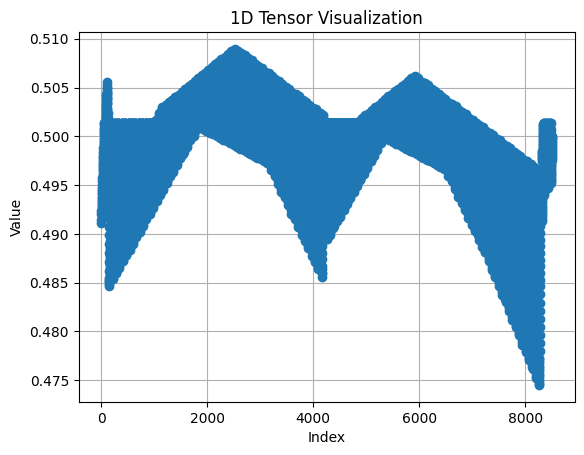

In [31]:


# prediction.cpu()
# Plotting
plt.plot(prediction.cpu().numpy(), marker='o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('1D Tensor Visualization')
plt.grid(True)
plt.show()

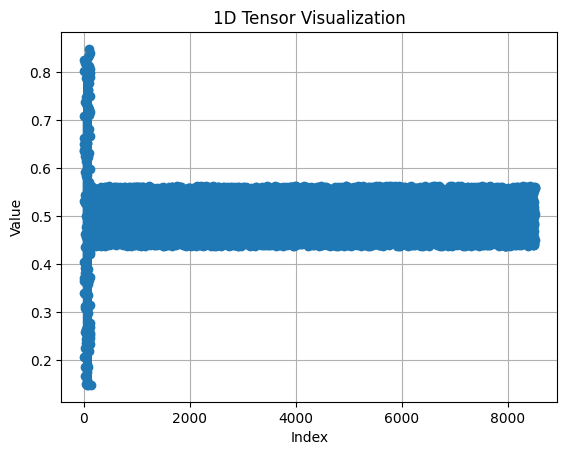

In [32]:
plt.plot(all_pixel_values.cpu().numpy(), marker='o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('1D Tensor Visualization')
plt.grid(True)
plt.show()